In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

VIEWVALUE = 0.25
BUYVALUE = 1
NNEIGHBOURS = 10
PRODUCT_TRES = 10
USER_TRES = 10
RATE_TRES = 0.25
K = 3
MAX_PRODUCTS = 10

In [2]:
sessions = pd.read_csv('s3://sagemaker-kh/dane/train_sessions.csv')
v_sessions = pd.read_csv('s3://sagemaker-kh/dane/valid_sessions.csv')
t_sessions = pd.read_csv('s3://sagemaker-kh/dane/test_sessions.csv')

In [3]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57765 entries, 0 to 57764
Data columns (total 8 columns):
Unnamed: 0            57765 non-null int64
session_id_1          57765 non-null int64
timestamp_1           57765 non-null object
user_id_1             57765 non-null int64
product_id_1          57765 non-null int64
event_type_1          57765 non-null object
offered_discount_1    57765 non-null int64
purchase_id_1         5016 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 3.5+ MB


In [4]:
v_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17037 entries, 0 to 17036
Data columns (total 8 columns):
Unnamed: 0            17037 non-null int64
session_id_1          17037 non-null int64
timestamp_1           17037 non-null object
user_id_1             17037 non-null int64
product_id_1          17037 non-null int64
event_type_1          17037 non-null object
offered_discount_1    17037 non-null int64
purchase_id_1         1390 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 1.0+ MB


In [5]:
t_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9946 entries, 0 to 9945
Data columns (total 8 columns):
Unnamed: 0            9946 non-null int64
session_id_1          9946 non-null int64
timestamp_1           9946 non-null object
user_id_1             9946 non-null int64
product_id_1          9946 non-null int64
event_type_1          9946 non-null object
offered_discount_1    9946 non-null int64
purchase_id_1         832 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 621.7+ KB


In [6]:
pd.merge(v_sessions[['user_id_1', 'product_id_1']], sessions[['user_id_1', 'product_id_1']], how='inner').head()

user_id_1  product_id_1
0        102          1002
1        102          1002
2        102          1042
3        102          1042
4        102          1042

In [7]:
pd.merge(sessions[['user_id_1', 'product_id_1']], t_sessions[['user_id_1', 'product_id_1']], how='inner').head()

user_id_1  product_id_1
0        102          1318
1        102          1318
2        102          1318
3        102          1318
4        102          1318

In [8]:
pd.merge(v_sessions[['user_id_1', 'product_id_1']], t_sessions[['user_id_1', 'product_id_1']], how='inner').head()

user_id_1  product_id_1
0        102          1002
1        102          1002
2        102          1042
3        102          1042
4        102          1042

In [9]:
pd.merge(pd.merge(sessions[['user_id_1', 'product_id_1']], v_sessions[['user_id_1', 'product_id_1']], how='inner'), t_sessions[['user_id_1', 'product_id_1']], how='inner').head()

user_id_1  product_id_1
0        102          1318
1        102          1318
2        102          1318
3        102          1318
4        102          1318

In [10]:
sessions.product_id_1.isnull().any()

False

In [11]:
sessions.user_id_1.isnull().any()

False

In [12]:
sessions.event_type_1.isnull().any()

False

In [13]:
gs = sessions[['user_id_1', 'product_id_1', 'event_type_1', 'timestamp_1']].groupby(['user_id_1', 'product_id_1', 'event_type_1']).count().unstack('event_type_1').fillna(0).reset_index()

In [14]:
gs.reset_index().head()

index user_id_1 product_id_1 timestamp_1             
event_type_1                              BUY_PRODUCT VIEW_PRODUCT
0                0       102         1001         6.0         12.0
1                1       102         1002         0.0          2.0
2                2       102         1003         2.0          4.0
3                3       102         1005         2.0          3.0
4                4       102         1006         0.0          1.0

In [15]:
ratings = pd.DataFrame({'user_id': gs.user_id_1, 'product_id': gs.product_id_1, 'rating': gs.timestamp_1.BUY_PRODUCT*BUYVALUE + gs.timestamp_1.VIEW_PRODUCT*VIEWVALUE})

In [16]:
ratings.head(10)

user_id  product_id  rating
0      102        1001    9.00
1      102        1002    0.50
2      102        1003    3.00
3      102        1005    2.75
4      102        1006    0.25
5      102        1008    0.50
6      102        1009    0.25
7      102        1010    0.25
8      102        1011    0.25
9      102        1012    0.25

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25615 entries, 0 to 25614
Data columns (total 3 columns):
user_id       25615 non-null int64
product_id    25615 non-null int64
rating        25615 non-null float64
dtypes: float64(1), int64(2)
memory usage: 600.4 KB


In [18]:
ratings.describe()

user_id    product_id        rating
count  25615.000000  25615.000000  25615.000000
mean     197.868436   1130.139840      0.710648
std       57.792448     96.971114      1.013856
min      102.000000   1001.000000      0.250000
25%      147.000000   1053.000000      0.250000
50%      195.000000   1108.000000      0.500000
75%      247.000000   1164.000000      0.750000
max      301.000000   1319.000000     13.000000

In [19]:
ratings[['product_id', 'rating']].groupby('product_id').count().describe()

rating
count  207.000000
mean   123.743961
std     10.816077
min    108.000000
25%    117.000000
50%    121.000000
75%    128.000000
max    171.000000

In [20]:
ratings[['user_id', 'rating']].groupby('user_id').count().describe()

rating
count  199.000000
mean   128.718593
std     59.708815
min      1.000000
25%     78.000000
50%    149.000000
75%    180.000000
max    202.000000

In [21]:
ratings[['product_id', 'rating']].groupby('product_id').count().describe()

rating
count  207.000000
mean   123.743961
std     10.816077
min    108.000000
25%    117.000000
50%    121.000000
75%    128.000000
max    171.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0258a9b518>]],
      dtype=object)

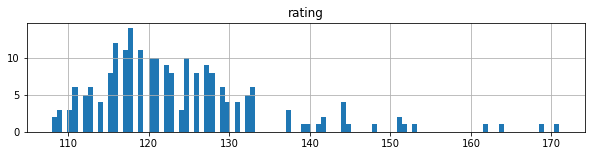

In [22]:
ratings[['product_id', 'rating']].groupby('product_id').count().hist(column="rating", bins=100, figsize=(10, 2))

In [23]:
ratings[['user_id', 'rating']].groupby('user_id').count().describe()

rating
count  199.000000
mean   128.718593
std     59.708815
min      1.000000
25%     78.000000
50%    149.000000
75%    180.000000
max    202.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0256b597b8>]],
      dtype=object)

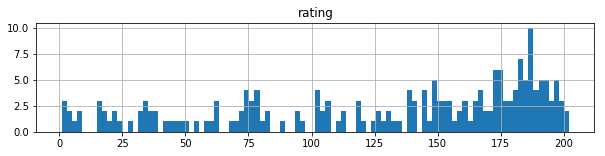

In [24]:
ratings[['user_id', 'rating']].groupby('user_id').count().hist(column="rating", bins=100, figsize=(10, 2))

Wybranie z datasetu tylko produktów, które zostały ocenione ponad PRODUCT_TRES razy

In [25]:
def get_ratings_from_sessions(sessions, buy_value, view_value, data_version):
    
    user_col = 'user_id_' + str(data_version)
    product_col = 'product_id_' + str(data_version)
    event_type_col = 'event_type_' + str(data_version)
    timestamp_col = 'timestamp_' + str(data_version)
    
    gs = sessions[[user_col, product_col, event_type_col, timestamp_col]].groupby([user_col, product_col, event_type_col]).count().unstack(event_type_col).fillna(0).reset_index()
    
    return pd.DataFrame({'user_id': gs[user_col], 'product_id': gs[product_col], 'rating': gs[timestamp_col].BUY_PRODUCT*buy_value + gs.timestamp_1.VIEW_PRODUCT*view_value})

In [26]:
ratings = get_ratings_from_sessions(sessions, BUYVALUE, VIEWVALUE, 1)

In [27]:
def get_matrix_from_ratings(ratings, product_treshold, user_treshold):
    
    products_count = ratings[['product_id', 'rating']].groupby('product_id', as_index=False).count()
    popular_products = products_count[products_count.rating >= PRODUCT_TRES]
    ratings_dropped_products = ratings[ratings.product_id.isin(popular_products.product_id)]
    
    users_count = ratings[['user_id', 'rating']].groupby('user_id', as_index=False).count()
    active_users = users_count[users_count.rating >= USER_TRES]
    ratings_dropped_users = ratings_dropped_products[ratings_dropped_products.user_id.isin(active_users.user_id)]

    mat = ratings_dropped_users.pivot(
            index='product_id', columns='user_id', values='rating').fillna(0)
    
    mat_shape = mat.shape
    
    product_ids_map = ratings_dropped_users.product_id.unique()
    user_ids_map = ratings_dropped_users.user_id.unique()
    
    return mat, mat_shape, product_ids_map, user_ids_map
    

In [28]:
mat, shape, p_map, u_map = get_matrix_from_ratings(ratings, PRODUCT_TRES, USER_TRES)
print(shape)
mat

(207, 191)


user_id      102   103   104   105   106   107   108   109   110   111  ...  \
product_id                                                              ...   
1001        9.00  5.75  3.00  5.75  0.50  1.75  1.50  7.50  4.75  6.75  ...   
1002        0.50  0.50  0.25  0.00  0.00  0.50  0.50  0.25  1.00  0.75  ...   
1003        3.00  1.50  1.25  0.00  0.00  2.75  3.00  0.00  7.00  3.00  ...   
1004        0.00  0.25  0.50  0.25  0.00  0.00  0.25  0.25  1.00  1.25  ...   
1005        2.75  2.75  3.00  1.50  0.00  1.50  1.50  2.00  3.00  1.50  ...   
1006        0.25  0.50  0.75  0.00  0.00  0.00  0.25  0.50  0.75  0.75  ...   
1007        0.00  0.25  0.75  0.25  0.00  0.25  0.25  0.25  0.50  0.75  ...   
1008        0.50  0.25  0.00  0.25  0.00  0.00  0.25  0.25  0.50  0.50  ...   
1009        0.25  0.25  0.50  0.00  0.00  0.25  0.50  0.50  0.50  0.50  ...   
1010        0.25  0.25  0.50  0.00  0.00  0.00  0.25  0.00  0.75  0.25  ...   
1011        0.25  0.25  0.50  0.25  0.00  0.00  0.50  0.00  0.50  1.00  ...   
1012        0.25  0.50  0.25  0.25  0.00  0.00  0.25  0.25  0.50  0.00  ...   
1013        0.50  0.50  0.50  0.00  0.00  0.00  0.25  0.50  0.75  0.50  ...   
1014        0.25  0.25  0.25  0.25  0.00  0.00  0.25  0.25  1.25  0.75  ...   
1015        0.50  0.00  0.25  0.25  0.00  0.00  0.00  0.50  0.50  0.50  ...   
1016        0.25  0.50  0.25  0.25  0.00  0.00  0.25  0.25  0.50  0.50  ...   
1017        0.25  0.00  0.75  0.50  0.00  0.75  0.25  0.50  0.50  0.25  ...   
1018        0.50  0.50  0.75  0.25  0.00  0.00  0.25  0.50  0.25  0.50  ...   
1019        0.50  0.50  0.25  0.25  0.00  0.00  0.25  0.00  1.00  0.25  ...   
1021        0.50  0.50  0.00  0.25  0.00  0.25  0.50  0.25  0.75  0.25  ...   
1022        0.00  0.50  0.50  0.25  0.00  0.00  0.25  0.00  0.75  0.25  ...   
1023        0.25  0.25  0.75  0.25  0.00  0.00  0.25  0.25  0.75  0.50  ...   
1024        0.25  0.25  0.25  0.25  0.00  0.00  0.25  0.25  0.50  0.50  ...   
1025        0.25  0.25  0.25  0.50  0.00  0.75  0.50  0.50  0.25  0.00  ...   
1026        0.50  0.25  0.50  0.25  0.00  0.00  0.25  0.50  1.00  0.50  ...   
1027        0.50  0.50  0.75  0.25  0.00  0.00  0.00  0.50  0.50  0.75  ...   
1028        0.25  0.25  0.75  0.25  0.00  0.00  0.25  0.25  0.75  0.25  ...   
1029        0.50  0.25  0.25  0.25  0.00  0.00  0.50  0.25  0.50  0.50  ...   
1030        0.00  0.75  0.50  0.75  0.00  0.25  0.75  0.75  0.25  0.25  ...   
1031        0.25  0.50  0.75  0.00  0.00  0.00  0.25  0.25  0.75  0.25  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1286        1.00  0.00  0.50  0.25  0.00  0.00  0.00  0.00  0.50  0.75  ...   
1287        1.00  0.00  0.25  0.50  0.00  0.00  0.00  0.25  0.50  0.75  ...   
1288        0.75  0.25  0.25  0.75  0.00  0.00  0.00  0.00  0.50  0.50  ...   
1289        0.50  0.00  0.50  0.25  0.00  0.00  0.00  0.25  0.50  1.00  ...   
1290        1.00  0.00  0.50  0.50  0.00  0.25  0.25  0.25  0.75  0.50  ...   
1291        5.50  1.25  0.50  3.00  0.00  0.00  1.25  0.00  0.75  6.00  ...   
1292        0.75  0.00  0.50  0.25  0.00  0.00  0.00  0.00  0.75  0.00  ...   
1293        1.00  0.00  0.25  0.25  0.00  0.00  0.25  0.25  0.25  0.75  ...   
1294        1.00  0.00  0.25  0.50  0.00  0.00  0.00  0.00  0.50  0.50  ...   
1295        1.00  0.25  0.50  0.50  0.00  0.00  0.00  0.25  0.25  0.50  ...   
1296        0.75  0.00  0.50  0.50  0.00  0.00  0.25  0.25  0.50  0.25  ...   
1297        0.75  0.25  0.50  0.50  0.00  0.00  0.25  0.00  0.75  1.00  ...   
1298        1.00  0.00  0.50  0.50  0.00  0.00  0.00  0.00  0.50  1.00  ...   
1299        1.00  0.00  0.50  0.50  0.00  0.00  0.00  0.00  0.75  1.25  ...   
1301        0.75  0.25  0.50  0.25  0.00  0.00  0.00  0.00  0.50  0.75  ...   
1303        1.00  0.00  0.00  0.50  0.00  0.25  0.00  0.00  0.50  0.25  ...   
1304        0.75  0.00  0.50  0.25  0.00  0.00  0.00  0.25  0.50  0.75  ...   
1305        1.00  0.00  0.25  0.25  0.00  0.00  0.

In [29]:
def train_model(n_neighbours, data):
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbours, n_jobs=-1)
    products_users_mat = csr_matrix(data)
    # fit
    model_knn.fit(products_users_mat)
    
    return model_knn, products_users_mat

In [98]:
def make_recommendation(model_knn, products_users_mat, products, n_recommendations, p_map, u_map, K):
    
    p_dict = { i : p_map[i] for i in range(0, len(p_map.tolist())) }
    reversed_p_dict = {value : key for (key, value) in p_dict.items()}
    
    raw_recommends = pd.DataFrame({'product_id': pd.Series([], dtype='int64'), 'distance': pd.Series([], dtype='float64')})
    
    for product in products:
        idx = reversed_p_dict[product]
        distances, indices = model_knn.kneighbors(products_users_mat[idx], n_recommendations+1)
        rec =  pd.DataFrame({'product_id': pd.Series(map(lambda x: p_dict[x], indices[0].tolist())), 'distance': pd.Series(distances[0])}).drop(0)
        raw_recommends = raw_recommends.append(rec, ignore_index = True)

    factor = len(products) + 1
    product_count = raw_recommends.groupby('product_id', as_index=False).count()
    product_dist = raw_recommends.groupby('product_id', as_index=False).mean()
    product_dist = pd.merge( product_dist, product_count, on='product_id')
    product_dist["new_distance"] = product_dist.distance_x*(factor - product_dist.distance_y)
    return product_dist.sort_values(by="new_distance").product_id.head(K).tolist()
    



In [100]:
products = [1130, 1006, 1281]
model_knn, pumat = train_model(NNEIGHBOURS, mat)
recom = make_recommendation(model_knn, pumat, products, 10, p_map, u_map, K)
recom

[1131, 1024, 1017]

In [115]:
def get_metrics(relevant_products, recommended_products, K):
  
    recommended = recommended_products[:K]
    recommended_in_relevant = list(set(recommended) & set(relevant_products))
    rec_in_rel_count = len(recommended_in_relevant)
    precision = rec_in_rel_count / K
    recall = len(list(set(recommended) & set(relevant_products[:0])))
    
    return precision, recall

In [113]:
get_metrics([1063, 1021, 1110], recom, K)

[1028, 1276, 1039]


(0.0, 0)

In [105]:
def random_session(sessions, n, data_version, K):
    event_type_col = 'event_type_' + str(data_version)
    session_col = 'session_id_' + str(data_version)
    
    sessions = sessions[sessions[event_type_col]=="VIEW_PRODUCT"]
    sessions = sessions.groupby(session_col).filter(lambda x : len(x)>K+1)
    sessions_ids = sessions[session_col].tolist()
    session_count = sessions[session_col].nunique()
    random_idx = np.random.choice(range(session_count), n, replace=False)
    
    s_dict = { i : sessions_ids[i] for i in range(0, len(sessions_ids)) }
    return pd.Series(map(lambda x: s_dict[x], random_idx.tolist()))

In [111]:
r_sessions = random_session(v_sessions, 30, 1, K)
r_sessions

0     100066
1     100399
2     100519
3     100335
4     100519
5     100519
6     100611
7     100399
8     100247
9     100178
10    100238
11    100608
12    100247
13    100399
14    100399
15    100240
16    100335
17    100066
18    100391
19    100399
20    100178
21    100080
22    100391
23    100523
24    100066
25    100335
26    100238
27    100129
28    100519
29    100245
dtype: int64

In [116]:
data_version = 1
product_col = 'product_id_' + str(data_version)
session_col = 'session_id_' + str(data_version)
event_type_col = 'event_type_' + str(data_version)
v_ses = v_sessions[v_sessions[event_type_col]=="VIEW_PRODUCT"]
precision_sum = 0
recall_sum = 0
for ses in r_sessions:
    ses_list = v_ses[v_ses[session_col] == ses]
    product_list = ses_list[product_col].tolist()
    seen_products_count = min(MAX_PRODUCTS, len(product_list) - K)
    seen_products = product_list[:seen_products_count]
    relevant_products = product_list[seen_products_count:]
    recom = make_recommendation(model_knn, pumat, seen_products, 10, p_map, u_map, K)
    p, r = get_metrics(relevant_products, recom, K)
    precision_sum += p
    recall_sum += r
    
precision = precision_sum/30
recall = recall_sum/30
print(precision)
print(recall)


0.2777777777777778
0.0
